In [5]:
import pandas as pd
from notebooks.consts import *

csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)
from notebooks.notebook_utils import log_correction, get_unique_human_genes

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan)  # to avoid log 0
genes_u = get_unique_human_genes(all_data_no_nan)

from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)

from tauso.new_model.data_handling import get_populated_df_with_structure_features

# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']

# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

all_data_human_gene = get_populated_df_with_structure_features(all_data_human_gene, genes_u, gene_to_data)

In [11]:
import pandas as pd
import subprocess
import os
import tempfile
import sys
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from Bio.Seq import Seq
from tqdm import tqdm

# --- User Imports ---
from notebooks.consts import *
from notebooks.notebook_utils import log_correction, get_unique_human_genes, read_cached_gene_to_data

# ================= CONFIGURATION =================
csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
INPUT_CSV = str(csv_path)

OLIGOWALK_EXE = "OligoWalk"
WINDOW_SIZE = 800
# HARDCODED PATH TO DATA TABLES
DATAPATH_VAL = "/home/michael/anaconda3/envs/tauso/share/rnastructure/data_tables/"

# GLOBAL VARIABLE FOR WORKERS (Avoids pickling large data repeatedly)
GENE_DATA_CACHE = None
# =================================================

def get_target_site_seq(aso_seq_str):
    """Converts ASO to Target Site (RevComp)."""
    clean_seq = ''.join(c for c in aso_seq_str if c.isalpha())
    return str(Seq(clean_seq).reverse_complement())

def run_single_aso(row, gene_data):
    """
    Core logic to run Oligowalk for one row.
    """
    metrics = {
        'OW_Overall': None,
        'OW_Duplex': None,
        'OW_Tm': None,
        'OW_Break_Target': None,
        'OW_Intra_Oligo': None,
        'error': None
    }

    aso_seq = row['Sequence']
    gene_name = row[CANONICAL_GENE]

    # 1. Validation
    if gene_name not in gene_data:
        metrics['error'] = 'Gene missing'
        return pd.Series(metrics)

    try:
        full_target_seq = gene_data[gene_name].full_mrna
    except AttributeError:
        metrics['error'] = 'No mRNA seq'
        return pd.Series(metrics)

    target_site = get_target_site_seq(aso_seq)

    # 2. Find Window
    idx = full_target_seq.upper().find(target_site.upper())
    if idx == -1:
        metrics['error'] = 'Site not found'
        return pd.Series(metrics)

    start = max(0, idx - WINDOW_SIZE // 2)
    end = min(len(full_target_seq), idx + len(target_site) + WINDOW_SIZE // 2)
    window_seq = full_target_seq[start:end]

    expected_pos = (idx - start) + 1

    # 3. Prepare Files
    # Use PID in filename to avoid collisions between parallel workers
    pid = os.getpid()
    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix=f'_{pid}.fasta') as tmp_in:
        tmp_in.write(f">window\n{window_seq}\n")
        tmp_in_name = tmp_in.name
    tmp_out_name = tmp_in_name + ".out"

    # 4. Run Tool
    cmd = [
        OLIGOWALK_EXE, tmp_in_name, tmp_out_name,
        "-m", "1",
        "-l", str(len(aso_seq))
    ]

    my_env = os.environ.copy()
    my_env["DATAPATH"] = DATAPATH_VAL

    try:
        subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, env=my_env)

        # 5. Parse
        if os.path.exists(tmp_out_name):
            with open(tmp_out_name, 'r') as f:
                for line in f:
                    parts = line.split()
                    if len(parts) < 7 or not parts[0].isdigit(): continue

                    if int(parts[0]) == expected_pos:
                        metrics['OW_Overall'] = float(parts[2])
                        metrics['OW_Duplex'] = float(parts[3])
                        metrics['OW_Tm'] = float(parts[4])
                        metrics['OW_Break_Target'] = float(parts[5])
                        metrics['OW_Intra_Oligo'] = float(parts[6])
                        break
        else:
             metrics['error'] = 'Output file missing'

        if metrics['OW_Overall'] is None and metrics['error'] is None:
            metrics['error'] = f'Pos {expected_pos} not in report'

    except Exception as e:
        metrics['error'] = str(e)
    finally:
        if os.path.exists(tmp_in_name): os.remove(tmp_in_name)
        if os.path.exists(tmp_out_name): os.remove(tmp_out_name)

    return pd.Series(metrics)

def worker_wrapper(row):
    """
    Wrapper function for parallel execution.
    Uses the global GENE_DATA_CACHE to avoid pickling overhead.
    """
    return run_single_aso(row, GENE_DATA_CACHE)

# ================= EXECUTION =================

def main():
    global GENE_DATA_CACHE

    print(f"Loading data from {INPUT_CSV}...")
    all_data = pd.read_csv(INPUT_CSV, low_memory=False)

    # Filter valid genes
    all_data = all_data.dropna(subset=[INHIBITION])
    genes_u = get_unique_human_genes(all_data)

    print("Loading gene cache...")
    # Load data into global variable BEFORE starting parallel pool
    GENE_DATA_CACHE = read_cached_gene_to_data(genes_u)

    # Work on valid rows
    df_process = all_data[all_data[CANONICAL_GENE].isin(genes_u)].copy()

    # Identify number of workers (cores)
    num_workers = max(1, multiprocessing.cpu_count() - 2) # Leave 2 cores free for system
    print(f"Running OligoWalk on {len(df_process)} candidates using {num_workers} parallel workers...")

    # Convert dataframe rows to a list for the executor
    # iterrows() is slow, but acceptable for sending tasks.
    # Converting to list of Series objects to pass to map.
    rows_to_process = [row for _, row in df_process.iterrows()]

    results_list = []

    # --- PARALLEL EXECUTION WITH PROGRESS BAR ---
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        # Submit tasks
        # tqdm wraps the executor.map iterator to show progress
        results_list = list(tqdm(
            executor.map(worker_wrapper, rows_to_process),
            total=len(rows_to_process),
            desc="OligoWalk Parallel"
        ))

    # Convert list of Series back to DataFrame
    results_df = pd.DataFrame(results_list, index=df_process.index)

    # Merge results back into original DataFrame
    all_data = all_data.join(results_df)

    print("\n--- Processing Complete ---")
    print("Updated 'all_data' columns:")
    print(all_data[['Sequence', 'OW_Overall', 'OW_Break_Target', 'OW_Tm']].head())

    return all_data

if __name__ == "__main__":
    final_df = main()

Loading data from /home/michael/career/tauso_article/tauso_source/notebooks/data/data_asoptimizer_updated.csv...
Loading gene cache...
Running OligoWalk on 31551 candidates using 30 parallel workers...


OligoWalk Parallel: 100%|██████████| 31551/31551 [12:40<00:00, 41.48it/s] 



--- Processing Complete ---
Updated 'all_data' columns:
           Sequence  OW_Overall  OW_Break_Target  OW_Tm
0  GCTAAAACAAATGCTA       -20.5              0.0   69.5
1  TATAATGGTGAATATC       -19.6              0.0   65.4
2  GCATGAAGATTTCTGG       -24.8              0.0   74.1
3  GGTGAATATCTTCAAA       -20.8              0.0   68.4
4  CACTTGTACTAGTATG       -21.4              0.0   72.8


In [12]:
from notebooks.features.feature_extraction import save_feature

save_feature(final_df, 'OW_Overall')

n = 30536
Spearman Correlation (r): -0.059
P-value: 2.35e-25


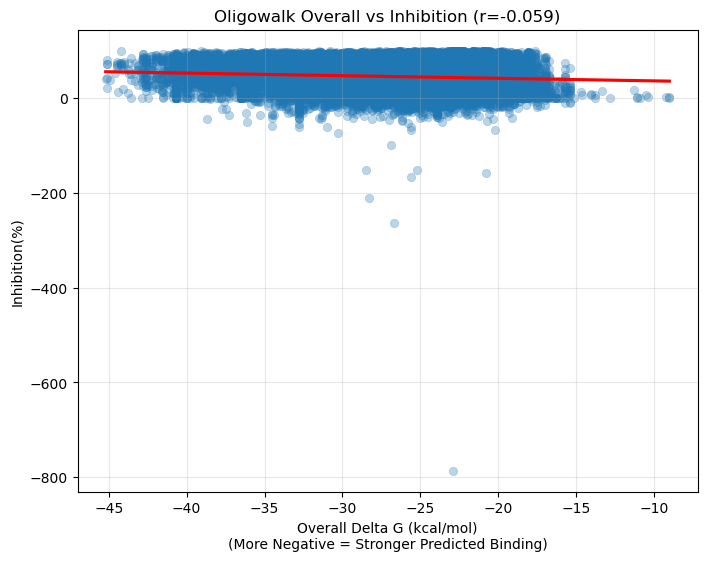

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 1. Clean Data (Remove rows where OligoWalk failed or Inhibition is missing)
df_corr = final_df.dropna(subset=[INHIBITION, 'OW_Overall'])

# 2. Calculate Spearman Correlation (Rank-based is better for biological data)
corr, p_val = spearmanr(df_corr['OW_Overall'], df_corr[INHIBITION])

print(f"n = {len(df_corr)}")
print(f"Spearman Correlation (r): {corr:.3f}")
print(f"P-value: {p_val:.2e}")

# 3. Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_corr, x='OW_Overall', y=INHIBITION, alpha=0.3, edgecolor=None)
sns.regplot(data=df_corr, x='OW_Overall', y=INHIBITION, scatter=False, color='red')

plt.title(f"Oligowalk Overall vs Inhibition (r={corr:.3f})")
plt.xlabel("Overall Delta G (kcal/mol)\n(More Negative = Stronger Predicted Binding)")
plt.ylabel(INHIBITION)
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_1574704/1521795752.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = spearmanr(group[FEATURE_COL], group[INHIBITION_COL])


Analyzed 25 cohorts with n >= 20

--- Top 5 Best Correlations (Negative is Good) ---
                          Cohort  Spearman_r  Count       P_Value
24                Yap1 (SNU-449)   -0.401194   1119  1.607425e-44
14                  PKK (HepaRG)   -0.242350   1042  2.152643e-15
11                  K-RAS (A431)   -0.120927    925  2.274225e-04
19  SNHG14 (Human Neuronal Cell)   -0.106609   1805  5.649302e-06
16                SNCA (SH-SY5Y)   -0.101249   1577  5.627011e-05

--- Bottom 5 Correlations (Positive/Unexpected) ---
                         Cohort  Spearman_r  Count       P_Value
17  SNCA_LNA (PAC neurons asyn)    0.385037    264  9.301447e-11
21                 SOD-1 (A431)    0.413190    429  4.050733e-19
4                  HTRA1 (U251)    0.493807    133  1.542836e-09
15             SNCA (Human IPS)    0.539614     24  6.499556e-03
2                  HIF1A (Hela)         NaN    128           NaN


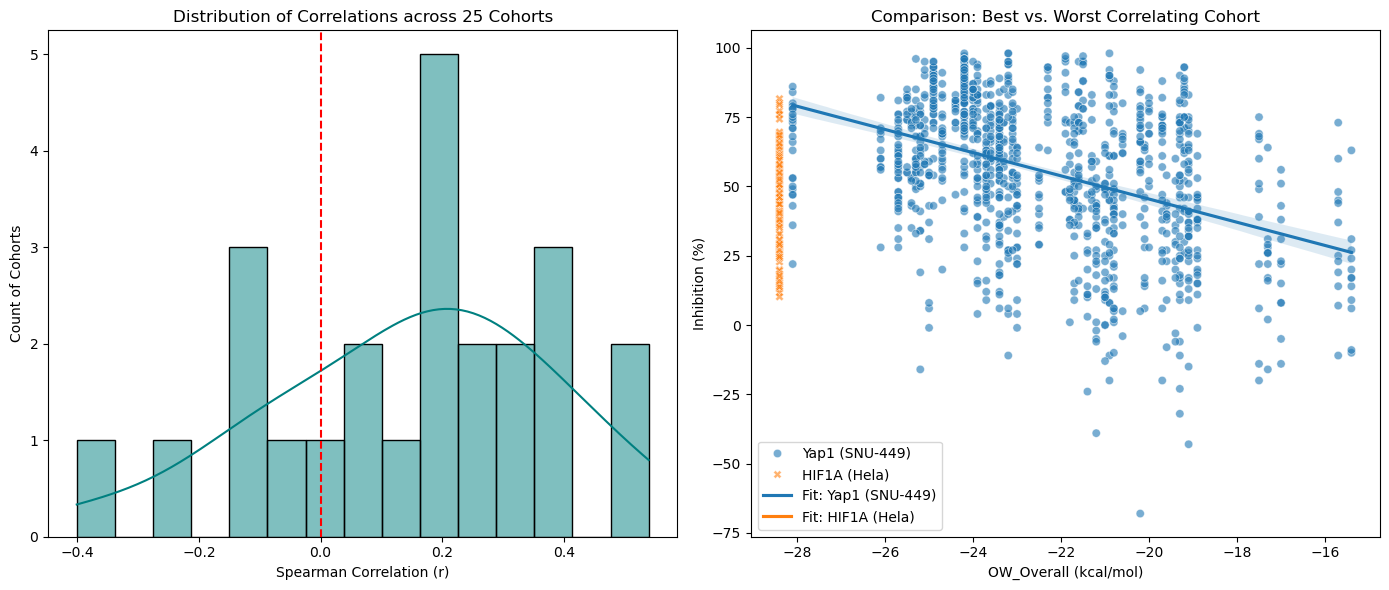

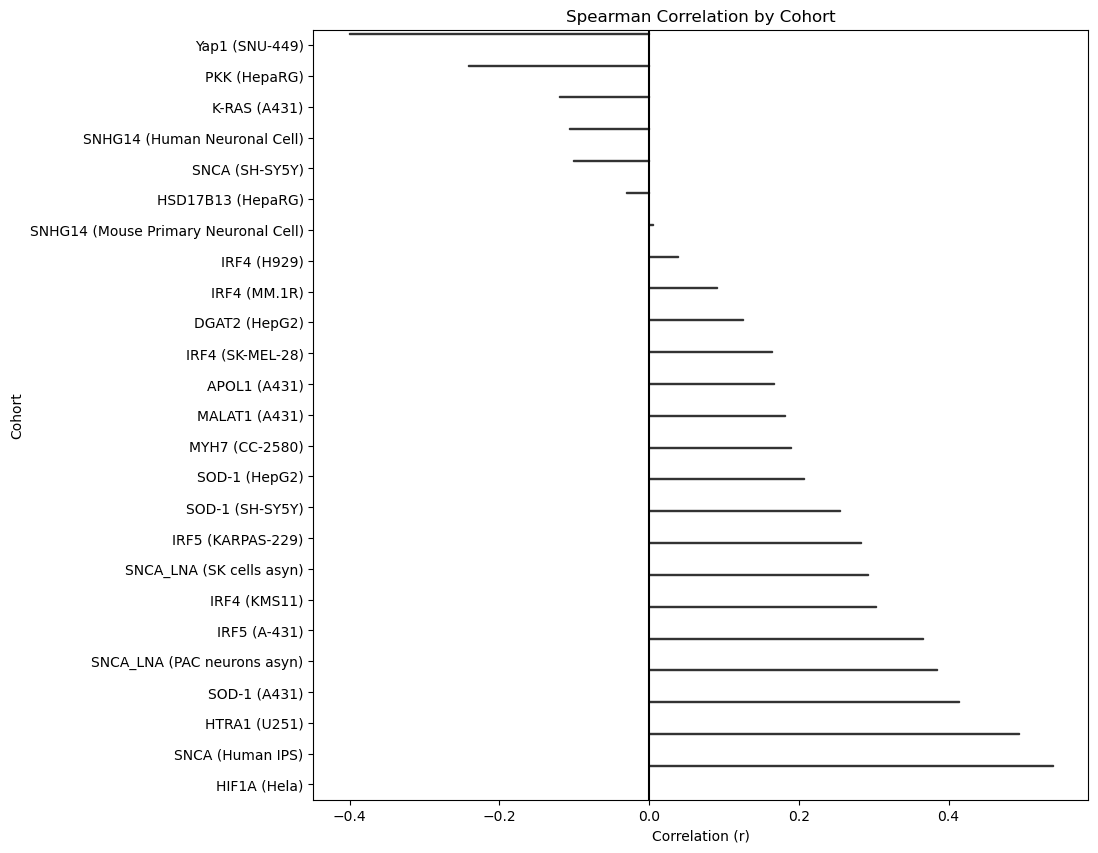

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

# --- CONFIGURATION ---
MIN_SAMPLES = 20  # Only analyze cohorts with at least 20 ASOs
INHIBITION_COL = 'Inhibition(%)' # Ensure this matches your column name
FEATURE_COL = 'OW_Overall'
# ---------------------

# 1. Prepare Data
df_analysis = final_df.dropna(subset=[INHIBITION_COL, FEATURE_COL]).copy()
df_analysis['Cohort'] = df_analysis['Target_gene'] + " (" + df_analysis['Cell_line'] + ")"

# 2. Calculate Correlation per Cohort
cohort_stats = []

for cohort, group in df_analysis.groupby('Cohort'):
    if len(group) < MIN_SAMPLES:
        continue

    corr, p_val = spearmanr(group[FEATURE_COL], group[INHIBITION_COL])

    cohort_stats.append({
        'Cohort': cohort,
        'Gene': group['Target_gene'].iloc[0],
        'Cell_Line': group['Cell_line'].iloc[0],
        'Spearman_r': corr,
        'P_Value': p_val,
        'Count': len(group)
    })

df_stats = pd.DataFrame(cohort_stats).sort_values('Spearman_r')

# 3. Print Summary
print(f"Analyzed {len(df_stats)} cohorts with n >= {MIN_SAMPLES}")
print("\n--- Top 5 Best Correlations (Negative is Good) ---")
print(df_stats.head(5)[['Cohort', 'Spearman_r', 'Count', 'P_Value']])

print("\n--- Bottom 5 Correlations (Positive/Unexpected) ---")
print(df_stats.tail(5)[['Cohort', 'Spearman_r', 'Count', 'P_Value']])

# 4. Visualization
plt.figure(figsize=(14, 6))

# Plot A: Histogram of Correlations
plt.subplot(1, 2, 1)
sns.histplot(df_stats['Spearman_r'], bins=15, kde=True, color='teal')
plt.axvline(x=0, color='red', linestyle='--')
plt.title(f"Distribution of Correlations across {len(df_stats)} Cohorts")
plt.xlabel("Spearman Correlation (r)")
plt.ylabel("Count of Cohorts")

# Plot B: Scatter plot of the 'Best' Cohort vs 'Worst' Cohort
# Pick the most negative (best) and most positive (worst/flat)
if not df_stats.empty:
    best_cohort = df_stats.iloc[0]['Cohort']
    worst_cohort = df_stats.iloc[-1]['Cohort']

    df_subset = df_analysis[df_analysis['Cohort'].isin([best_cohort, worst_cohort])]

    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_subset, x=FEATURE_COL, y=INHIBITION_COL, hue='Cohort', style='Cohort', alpha=0.6)

    # Add regression lines manually to handle colors cleanly
    for cohort in [best_cohort, worst_cohort]:
        d = df_subset[df_subset['Cohort'] == cohort]
        sns.regplot(data=d, x=FEATURE_COL, y=INHIBITION_COL, scatter=False, label=f"Fit: {cohort}")

    plt.title("Comparison: Best vs. Worst Correlating Cohort")
    plt.xlabel(f"{FEATURE_COL} (kcal/mol)")
    plt.ylabel("Inhibition (%)")
    plt.legend()

plt.tight_layout()
plt.show()

# 5. Full Heatmap (Optional: Visualizing all slopes)
# Normalize axes to compare slopes visually?
# Usually simply plotting the r-values as a bar chart is clearer.
plt.figure(figsize=(10, len(df_stats)*0.4))
sns.barplot(data=df_stats, x='Spearman_r', y='Cohort', hue='Spearman_r',
            palette='seismic', saturation=1, edgecolor='0.2', legend=False)
plt.axvline(x=0, color='black', linestyle='-')
plt.title("Spearman Correlation by Cohort")
plt.xlabel("Correlation (r)")
plt.show()